# Convolutional Autoencoder with GROMACS data

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets('MNIST_data', validation_size=0)
f = open('data/md_0_seg.txt','r')
input_data = f.readlines()

for i in range(1,100):
    f = open('data/md_'+str(i)+'_seg.txt','r')
    input_data = np.concatenate([input_data,f.readlines()],0)

# input_data = np.concatenate([input_data0,input_data1,input_data2],0)
print(np.shape(input_data))
# print(input_data[1000])
input_data = [[float(line.split(' ')[1]),float(line.split(' ')[2]),float(line.split(' ')[3])] for line in input_data]
print(np.shape(input_data))

(10000000,)
(10000000, 3)


In [3]:
data = np.reshape(input_data,[10000,1000,3])

In [4]:
print(np.shape(data))

(10000, 1000, 3)


In [12]:
learning_rate = 0.000003
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, [None, 100,30,1])
targets_ = tf.placeholder(tf.float32, [None, 100,30,1])

### Encoder
# stride = 1, padding = same doesn't change the height and width 
conv1 = tf.layers.conv2d(inputs_, filters=8,kernel_size=[2,2],strides=(1, 1),padding='same', activation=tf.nn.relu)
print(conv1)
# Now 28x28x16 100 30 8
maxpool1 = tf.layers.max_pooling2d(conv1,pool_size=[2,2],strides=2,padding='same',name=None) # stride cut the size
print(maxpool1)
# Now 14x14x16 50 15 8
conv2 = tf.layers.conv2d(maxpool1, filters=16,kernel_size=[2,2],strides=(1, 1),padding='same', activation=tf.nn.relu)
print(conv2)
# Now 14x14x8 50 15 16
maxpool2 = tf.layers.max_pooling2d(conv2,pool_size=[2,2],strides=5,padding='same',name=None)
print(maxpool2)
encoded = maxpool2
# Now 7x7x8 10 3 16
conv3 = tf.layers.conv2d(maxpool2, filters=32,kernel_size=[2,2],strides=(1, 1),padding='same', activation=tf.nn.relu)
print(conv3)
# Now 7x7x8 10 3 32
encoded = tf.layers.max_pooling2d(conv3,pool_size=[2,2],strides=2,padding='same',name=None)
print(encoded)
# Now 4x4x8 5 2 32

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded,[10,3])
print(upsample1)
# Now 7x7x8 10 3 32
# upsample1 = encoded
conv4 = tf.layers.conv2d_transpose(upsample1,filters=16, kernel_size=[2,2],strides=(1,1),padding='same', activation=tf.nn.relu)
print(conv4)
# Now 7x7x8 10 3 16
upsample2 = tf.image.resize_nearest_neighbor(conv4,[50,15])
print(upsample2)
# Now 14x14x8 50 15 16
conv5 = tf.layers.conv2d_transpose(upsample2,filters=8, kernel_size=[2,2],strides=(1,1),padding='same', activation=tf.nn.relu)
# Now 14x14x8 50 15 8
upsample3 = tf.image.resize_nearest_neighbor(conv5,[100,30])
# Now 28x28x8 100 30 8
conv6 = tf.layers.conv2d_transpose(upsample3,filters=1, kernel_size=[2,2],strides=(1,1),padding='same', activation=tf.nn.relu)
# Now 28x28x16 100 30 1
print(conv6)

logits = conv6
# logits = tf.layers.conv2d_transpose(conv6,filters=1, kernel_size=[3,3],strides=(1,1),padding='same',activation=None)
#Now 28x28x1 100 30 1
# print(logits)

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# # Pass logits through sigmoid and calculate the cross-entropy loss
# loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
print(targets_)
print(logits)
error = tf.reduce_mean(tf.pow(targets_-logits,2), name='mean_squared_error')
# Get cost and define the optimizer
# cost = tf.reduce_mean(loss)
cost = error
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Tensor("conv2d_3/Relu:0", shape=(?, 100, 30, 8), dtype=float32)
Tensor("max_pooling2d_3/MaxPool:0", shape=(?, 50, 15, 8), dtype=float32)
Tensor("conv2d_4/Relu:0", shape=(?, 50, 15, 16), dtype=float32)
Tensor("max_pooling2d_4/MaxPool:0", shape=(?, 10, 3, 16), dtype=float32)
Tensor("conv2d_5/Relu:0", shape=(?, 10, 3, 32), dtype=float32)
Tensor("max_pooling2d_5/MaxPool:0", shape=(?, 5, 2, 32), dtype=float32)
Tensor("ResizeNearestNeighbor_3:0", shape=(?, 10, 3, 32), dtype=float32)
Tensor("conv2d_transpose_3/Relu:0", shape=(?, 10, 3, 16), dtype=float32)
Tensor("ResizeNearestNeighbor_4:0", shape=(?, 50, 15, 16), dtype=float32)
Tensor("conv2d_transpose_5/Relu:0", shape=(?, 100, 30, 1), dtype=float32)
Tensor("Placeholder_3:0", shape=(?, 100, 30, 1), dtype=float32)
Tensor("conv2d_transpose_5/Relu:0", shape=(?, 100, 30, 1), dtype=float32)


## Training

In [13]:
sess = tf.Session()

In [14]:
epochs = 10000
sess.run(tf.global_variables_initializer())

In [22]:
for e in range(epochs):
#     for ii in range(mnist.train.num_examples//batch_size):
#         batch = mnist.train.next_batch(batch_size)
    imgs = data[e].reshape((-1, 100, 30, 1))
    imgs = np.multiply(imgs,10)
#     print(np.shape(imgs))
    batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                     targets_: imgs})
    if(e % 100 == 0):
        print("Epoch: {}/{}...".format(e+1, epochs),"Training loss: {:.4f}".format(batch_cost))

Epoch: 1/10000... Training loss: 38.2311
Epoch: 101/10000... Training loss: 37.9270
Epoch: 201/10000... Training loss: 37.8434
Epoch: 301/10000... Training loss: 37.9390
Epoch: 401/10000... Training loss: 38.0352
Epoch: 501/10000... Training loss: 38.1391
Epoch: 601/10000... Training loss: 38.2145
Epoch: 701/10000... Training loss: 38.3118
Epoch: 801/10000... Training loss: 38.4479
Epoch: 901/10000... Training loss: 38.3552
Epoch: 1001/10000... Training loss: 38.3857
Epoch: 1101/10000... Training loss: 38.2398
Epoch: 1201/10000... Training loss: 38.2091
Epoch: 1301/10000... Training loss: 38.1284
Epoch: 1401/10000... Training loss: 38.1549
Epoch: 1501/10000... Training loss: 38.2092
Epoch: 1601/10000... Training loss: 38.3691
Epoch: 1701/10000... Training loss: 38.3433
Epoch: 1801/10000... Training loss: 38.3005
Epoch: 1901/10000... Training loss: 38.3243
Epoch: 2001/10000... Training loss: 38.2686
Epoch: 2101/10000... Training loss: 38.1310
Epoch: 2201/10000... Training loss: 37.9162


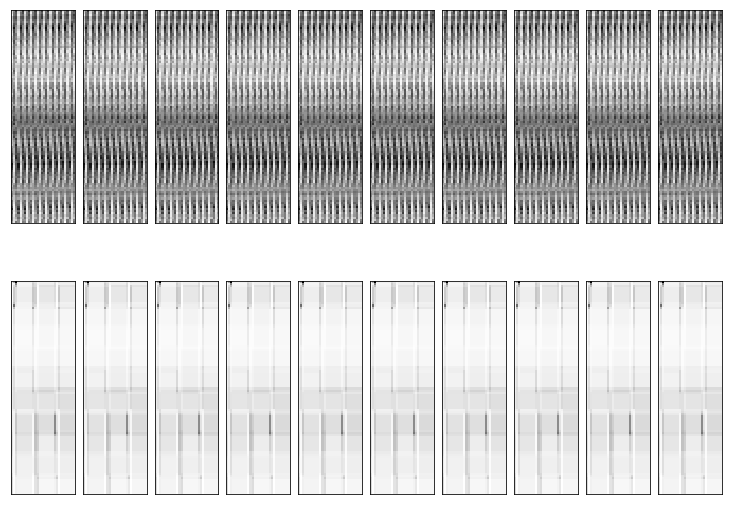

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(10,8))
# in_imgs = mnist.test.images[:10]
in_imgs = data[0:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 100, 30, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((100, 30)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [10]:
# sess.close()

In [11]:
print(np.shape(reconstructed))

(10, 100, 30, 1)
